In [1]:
from my_commonfunctions import *

In [2]:
def get_index_of_max_area_contour(contours):
    i = 0
    i_max = 0
    area_max = 0
    for c in contours:
        area = cv2.contourArea(c)
        if area > area_max:
            area_max = area
            i_max = i
        i += 1

    return i_max

In [553]:
def derotate_and_crop(img_gray):    
    # Derotate
    angle = get_rotation_angle(img_gray)
    gray_rotated = rotate_bound(img_gray, angle)

    # Adaptive thresh & canny
    thresh = cv2.adaptiveThreshold(gray_rotated, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 11)
    if img_gray.shape[0] * img_gray.shape[1] > 900000:
        thresh = cv2.medianBlur(thresh, 3)
    edges = cv2.Canny(thresh, 100, 200)

    # Distance between staves & staff thickness
    distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(thresh)
    
    # Musical score mask
    kernel_size = distance_between_staves * 3
    k = np.ones((kernel_size, kernel_size))
    k2 = np.ones((int(kernel_size*1.5), int(kernel_size*1.5)))
    k3 = np.ones((kernel_size*6, kernel_size))
    dilated = cv2.dilate(edges, k)
    dilated_eroded = cv2.erode(dilated, k2)
    dilated_eroded_dilated = cv2.dilate(dilated_eroded, k3)

    # my_show_images([thresh, edges, dilated, dilated_eroded, dilated_eroded_dilated], row_max=2)
    
    # Bounding rectangle of the max area contour
    image, contours, hierarchy = cv2.findContours(dilated_eroded_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    i_max = get_index_of_max_area_contour(contours)
    x, y, w, h = cv2.boundingRect(contours[i_max])
    return gray_rotated[y:y+h, x:x+w], distance_between_staves, staff_thickness

In [454]:
def find_4_points(img):
    pts = np.transpose((np.nonzero(img)[1], np.nonzero(img)[0]))
    #pts = np.non(pts)
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [455]:
def deskew(img, musical_lines_points, kernel_size):
    points = find_4_points(musical_lines_points)
    
    diameter1 = math.sqrt((points[0][0]-points[2][0])**2+(points[0][1]-points[2][1])**2)
    diameter2 = math.sqrt((points[1][0]-points[3][0])**2+(points[1][1]-points[3][1])**2)
    
    direction1 = points[2]-points[0]
    direction2 = points[3]-points[1]
    
    points[0] = points[0] - 0.07 * direction1
    points[2] = points[2] + 0.07 * direction1
    
    points[1] = points[1] - 0.07 * direction2
    points[3] = points[3] + 0.07 * direction2


    points[0][1] = points[0][1] - kernel_size * 3.5 
    points[2][1] = points[2][1] + kernel_size * 3.5
    points[1][1] = points[1][1] - kernel_size * 3.5
    points[3][1] = points[3][1] + kernel_size * 3.5

    
    diameter1 = math.sqrt((points[0][0]-points[2][0])**2+(points[0][1]-points[2][1])**2)
    diameter2 = math.sqrt((points[1][0]-points[3][0])**2+(points[1][1]-points[3][1])**2)
    
    direction1 = points[2]-points[0]
    direction2 = points[3]-points[1]
    
    
    d = max(diameter1,diameter2)
    
    unit_direction1 = direction1 / np.linalg.norm(direction1)
    unit_direction2 = direction2 / np.linalg.norm(direction2)
    
    dot_product = np.dot(unit_direction1, unit_direction2)
    
    angle_between = np.arccos(dot_product)
    angle = (math.pi-angle_between)/2
    maxWidth  = round( d * math.cos(angle))
    maxHeight = round(d * math.sin(angle))
    
    # print(maxWidth)
    # print(maxHeight)
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(points, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight),borderValue=(255,255,255))
    # return the warped image
    return warped

In [634]:
img_gray = my_imread_gray('02.PNG')
derotated_croped_gray, distance_between_staves, staff_thickness = derotate_and_crop(img_gray)
print(distance_between_staves, staff_thickness)

16 1


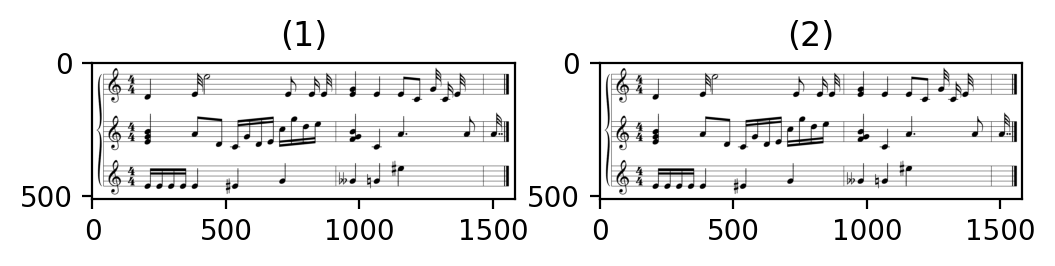

In [635]:
my_show_images([img_gray, derotated_croped_gray], row_max=2)

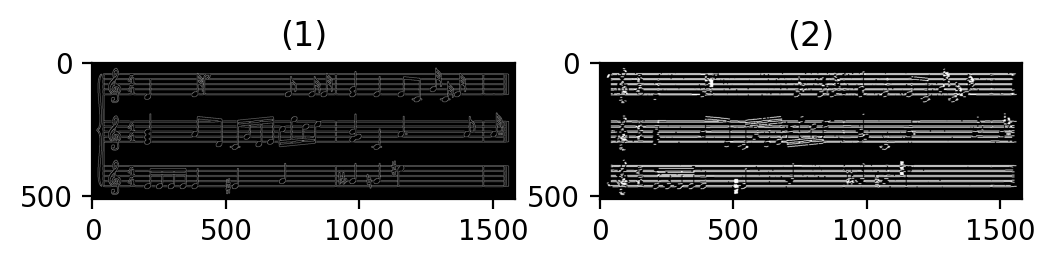

In [636]:
edges = canny(derotated_croped_gray, 2, 1, 25)
height = derotated_croped_gray.shape[0]
width = derotated_croped_gray.shape[1]
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3, theta=np.arange(np.pi/4, np.pi*3/4, np.pi/90))

lines_img = np.zeros(edges.shape)
for l in lines:
    x1 = l[0][0]
    y1 = l[0][1]
    x2 = l[1][0]
    y2 = l[1][1]
    #print(l)
    #print(x1, y1, x2, y2)
    cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), 2)

my_show_images([edges, lines_img], dpi=200, row_max=2)

In [637]:
lines_img.shape

(509, 1583)

16
False


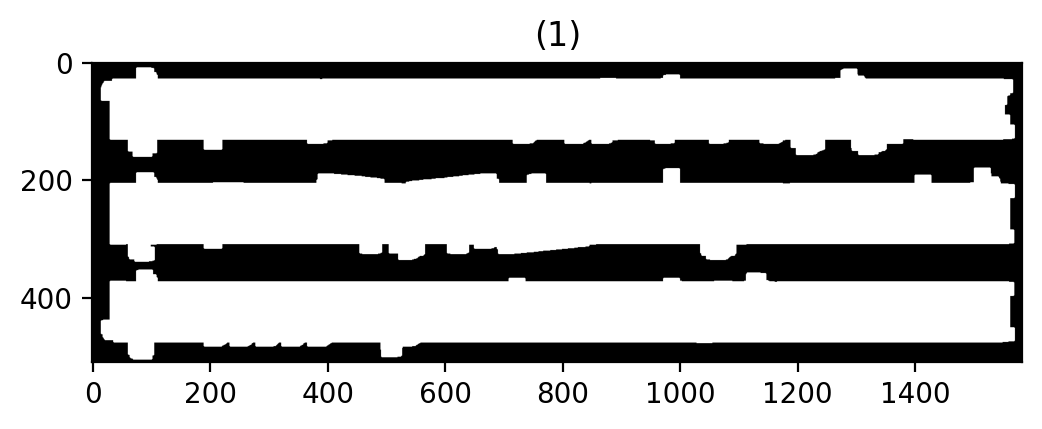

In [638]:
kernel_size = int(distance_between_staves*1.5)
k = np.ones((kernel_size, kernel_size))
k2_multiplier = 3 if np.cbrt(kernel_size) > 3 else np.cbrt(kernel_size) > 3
k2 = np.ones((int(kernel_size*k2_multiplier), int(kernel_size*k2_multiplier)))
print(distance_between_staves)
print(k2_multiplier)

musical_lines_mask = cv2.erode(cv2.dilate(lines_img, k), k2)
my_show_images([musical_lines_mask])

In [639]:
image, contours, hierarchy = cv2.findContours((musical_lines_mask*255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [640]:
musical_lines_mask_width = musical_lines_mask.shape[1]
contours_filtered = []
for c in contours:
    c = cv2.convexHull(c)
    # epsilon = 0.05*cv2.arcLength(c,True)
    # c = cv2.approxPolyDP(c,epsilon,True)
    x_points = c.T[0]
    #print(x_points)
    c_min_x = np.min(x_points)
    c_max_x = np.max(x_points)
    c_width = c_max_x - c_min_x
    #print(c_min_x, c_max_x, c_width)
    if c_width / musical_lines_mask_width >= .75: 
        contours_filtered.append(c)

len(contours_filtered)

3

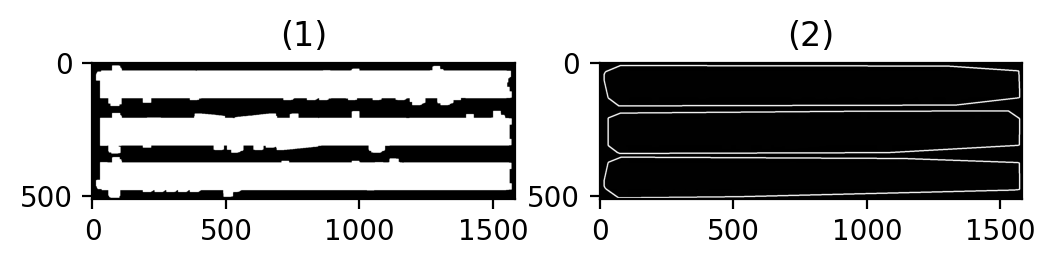

In [641]:
musical_lines_mask_contours_drawn = rgb2gray(cv2.drawContours(gray2rgb((musical_lines_mask*255).astype(np.uint8)), contours_filtered, -1, (255,255,255), 3))
my_show_images([musical_lines_mask, musical_lines_mask_contours_drawn], row_max=2)

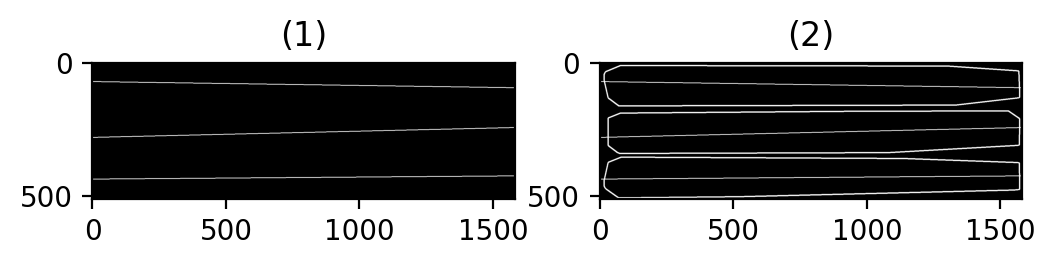

In [642]:
rows,cols = musical_lines_mask.shape[:2]

musical_lines_mask_contours_lines_drawn = np.zeros((rows, cols, 3))

for c in contours_filtered:
    [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    cv2.line(musical_lines_mask_contours_lines_drawn, (cols-1,righty), (0,lefty), (255,255,255),2)

musical_lines_mask_contours_lines_drawn = rgb2gray(musical_lines_mask_contours_lines_drawn)
musical_lines_points = (musical_lines_mask_contours_lines_drawn > 0.5) & (musical_lines_mask_contours_drawn > 0.5)

my_show_images([musical_lines_mask_contours_lines_drawn > 0.5, (musical_lines_mask_contours_lines_drawn > 0.5) | (musical_lines_mask_contours_drawn > 0.5)], row_max=2)

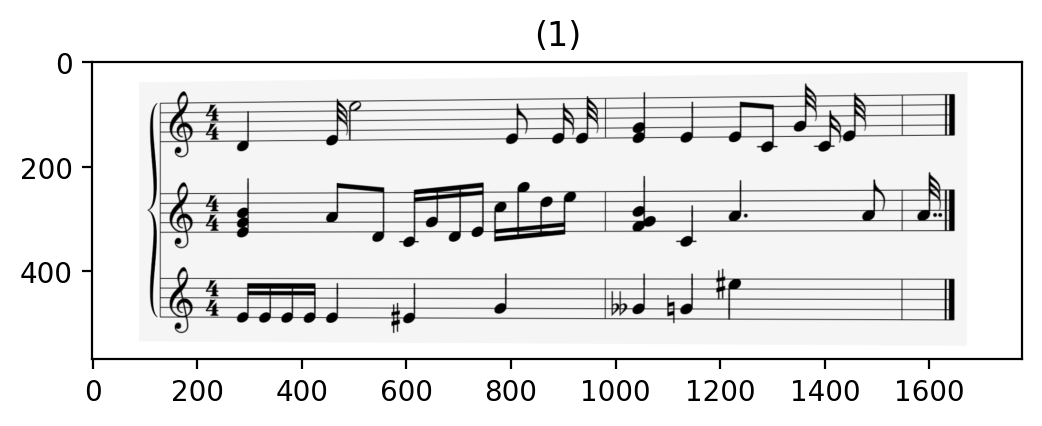

In [643]:
if len(contours_filtered) > 1:
    deskewed = deskew(derotated_croped_gray, musical_lines_points, kernel_size)
else:
    deskewed = deskew(derotated_croped_gray, musical_lines_mask_contours_drawn, kernel_size)
my_show_images([deskewed])

In [644]:
# io.imsave('deskewed_derotated.png', deskewed)